In [1]:
import sys
import glob
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# from scipy.interpolate import UnivariateSpline
# from scipy import stats
import pickle

from itertools import chain
from scipy.optimize import curve_fit

# Import ART

sys.path.append('.')
sys.path.append('../ART_iGEM')

from art.core import *
import art.plot as plot

Do not have mpi4py package.
Do not have acor package


# Step 1: Loading the data

The Automated Recommendation tool is used to determine which combination of *Saccharomyces spp.* strain, promotor, secretion peptide and alpha-amylase gene is expected to yield a high alpha-amylase activity. The training data for ART consists of alpha-amylase activity produced by 53 samples out of the possible 640 combinations. This activity was measured using the **X** kit. 



However, the first step is to load in the various data files and make sure they have the correct data type

In [2]:
samples = pd.read_csv('Sample_list.csv', sep=',')

# filtering out the non-existant measurments:

print(len(samples))

samples = samples.loc[samples['Measurement']!='_']
samples['Measurement'] = samples['Measurement'].astype('float64')
samples.info()
#print(len(samples))

#strains_art_oneh = strains.copy().loc[np.logical_or(strains['origin'] == 'lib', strains['origin'] == 'ctr')]



192
<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 0 to 188
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Line Name    162 non-null    object 
 1   Replicate    162 non-null    object 
 2   Measurement  162 non-null    float64
 3   str_idx      162 non-null    int64  
 4   pro_idx      162 non-null    int64  
 5   sec_idx      162 non-null    int64  
 6   gen_idx      162 non-null    int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 10.1+ KB


The info box above should show that the `Line Name` and `Replicate` columns have the Dtype `object`, the has the Dtype `float64` and all other columns have the Dtype `int64`

## Step 2: Restructuring the data

The ART needs a unique name for each replicate. Therefore, the `Line Name` and `Replicate` are combined into a single `Line Name`. Furthermore, ART is designed for the optimization of a genetically engineered machine in which the expression of several protein is varied. Under these circumstances, proteomic and transciptomic data is generally used as the input data (Radivojević, Costello & Workman et al., 2020). In our case however, the main interest lies within optimizing the activity of a single enzyme. As our focus is on the activity and not the abundance of the enzyme, proteomic data on the absolute protein content of the micro organism is not an representative performence measure. Furthermore, transcritomic data of the gene with encodes for alpha-amylase is not the only variable which can influence the activity of alpha-amylase. The strain in which the enzyme is produced, the secretion peptide of the protein and the variant of alpha-amylase also influence activity of the resulting enzyme. Therefore, a different measurement type is needed as input data. 

Zhang, Petersen & Radivojević et al. (2020) faced a similar problem. They varied the promoters of 5 different genes in order to optimize typtophan digestion in *Saccharomyces cerevisiae*. However, transcriptomic data of each gene was not available. What they did instead, was looking at which promoter combination yielded the best tryptophan digestion. Each promoter was given a unique index. By one-hot-encoding each of these indexes, the promotor combinations can be expressed in a sparse binary vector. This sparse vector can be used instead of the more common transcriptomic data. A similar approach was chosen for our project. Instead of looking at different promoters, other parts of the genetically engineered machine are optimized. Each of the part-variants is given a unique index which in turn can be translated to a one-hot-encoded vector.

Most of the code you see below is either taken directly from the publication of Zhang, Petersen & Radivojević et al. (2020), or it is heavily inspired by it.

#### References:
Radivojević, T., Costello, Z., Workman, K. et al. A machine learning Automated Recommendation Tool for synthetic biology. Nat Commun 11, 4879 (2020). https://doi.org/10.1038/s41467-020-18008-

Zhang, J., Petersen, S.D., Radivojević, T. et al. Combining mechanistic and machine learning models for predictive engineering and optimization of tryptophan metabolism. Nat Commun 11, 4880 (2020). https://doi.org/10.1038/s41467-020-17910-1

In [3]:
samples["Line Name"] = samples["Line Name"] + "-" + samples["Replicate"]

samples = samples.loc[:,['Line Name','Measurement','str_idx', 'pro_idx', 'sec_idx', 'gen_idx']]

In [4]:
samples_art_oneh = pd.get_dummies(data=samples, columns=['str_idx', 'pro_idx', 'sec_idx', 'gen_idx'])
samples_art_oneh.head()

,Line Name,Measurement,str_idx_1,str_idx_2,str_idx_3,str_idx_4,pro_idx_5,pro_idx_6,pro_idx_7,pro_idx_8,...,pro_idx_13,pro_idx_14,sec_idx_15,sec_idx_16,sec_idx_17,sec_idx_18,gen_idx_19,gen_idx_20,gen_idx_21,gen_idx_22
0,#01-r0,-5.919819,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
1,#01-r1,-5.911464,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
2,#01-r2,-5.900195,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,#02-r0,-10.527602,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
4,#02-r1,-10.644871,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0


After the transformation, the columns in the dataframe represent the line name of the machine, the corrected activity measure of this line and which part-variants were used in constructing this line. 

In [5]:
# store the columnnames as parameter setting for ART
colnames = samples_art_oneh.columns[2:].tolist()
print(colnames)

['str_idx_1', 'str_idx_2', 'str_idx_3', 'str_idx_4', 'pro_idx_5', 'pro_idx_6', 'pro_idx_7', 'pro_idx_8', 'pro_idx_9', 'pro_idx_10', 'pro_idx_11', 'pro_idx_12', 'pro_idx_13', 'pro_idx_14', 'sec_idx_15', 'sec_idx_16', 'sec_idx_17', 'sec_idx_18', 'gen_idx_19', 'gen_idx_20', 'gen_idx_21', 'gen_idx_22']


The input data is fed to the ART measurement by measurement. This makes it impossible to feed the entire one-hot encoded vector to the ART at once. The trick is to consider each entry in the one-hot-encoded vector as a 'measurement' on wether the line contains this part-variant. A `1.000000` in the `Value` column would indicate that the part-variant listed in the `Measurement Type` column is preset in the line listed in the `Line Name` column. A `0.000000` would indicate the oposite. 

In [6]:
# Pivot the dataframe and change the column names
samples_art_oneh = samples_art_oneh.set_index('Line Name').stack().reset_index()
samples_art_oneh.columns = ['Line Name', 'Measurement Type', 'Value']
print(samples_art_oneh)
samples_art_oneh.to_csv('test.csv')

     Line Name Measurement Type     Value
0       #01-r0      Measurement -5.919819
1       #01-r0        str_idx_1  0.000000
2       #01-r0        str_idx_2  1.000000
3       #01-r0        str_idx_3  0.000000
4       #01-r0        str_idx_4  0.000000
...        ...              ...       ...
3721    #63-r2       sec_idx_18  0.000000
3722    #63-r2       gen_idx_19  0.000000
3723    #63-r2       gen_idx_20  0.000000
3724    #63-r2       gen_idx_21  1.000000
3725    #63-r2       gen_idx_22  0.000000

[3726 rows x 3 columns]


## Step 3: Outlier detection

Measurements can be noisy and sometimes it is impossible to determine whether the results of a sample can be attributed to the functioning of the sample, of if the results are due to some random measuring error. This is the reason that each measurement was taken in triplicates. In theory, each replicate of the same sample should give a somewhat similar activity measurement. In practice, there is often one replicate that shows a substantially different activity compared to the other two measurements. The ART has an intergrated tool which can be used for exluding the samples in which the variance within the replicates of the same sample is greater than the variance within `x`% of all samples. This `x` needs to be guessed depending on the accuracy of the measurements.

In [7]:
measurement = ['Measurement']

In [8]:
noisy_line_name = utils.find_noisy_data(samples_art_oneh, measurement, percentile=90,plot_flag=False)
samples_art_oneh_filtered = utils.filter_noisy_data(samples_art_oneh, noisy_line_name, measurement, filter_all_replicates=True,plot_flag=False)


../ART_iGEM/art/utility.py:835: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df["Line Name"], df["Replicate"] = df["Line Name"].str.split("-").str


,Value,Measurement Type,Replicate Mean,Replicate Error
Line Name,,,,
#06-r0,-11.512925,Measurement,-10.200589,-1.312337
#06-r1,-7.575915,Measurement,-10.200589,2.624674
#06-r2,-11.512925,Measurement,-10.200589,-1.312337
#11-r0,-11.512925,Measurement,-10.109325,-1.403600
#11-r1,-7.302125,Measurement,-10.109325,2.807200
#11-r2,-11.512925,Measurement,-10.109325,-1.403600
#20-r0,-11.512925,Measurement,-9.130414,-2.382512
#20-r1,-4.365390,Measurement,-9.130414,4.765023
#20-r2,-11.512925,Measurement,-9.130414,-2.382512


,Line Name,Measurement Type,Value
207,#06-r0,Measurement,-11.512925
230,#06-r1,Measurement,-7.575915
253,#06-r2,Measurement,-11.512925
483,#11-r0,Measurement,-11.512925
506,#11-r1,Measurement,-7.302125
529,#11-r2,Measurement,-11.512925
1035,#20-r0,Measurement,-11.512925
1058,#20-r1,Measurement,-4.365390
1081,#20-r2,Measurement,-11.512925
1104,#21-r0,Measurement,-9.028118


In [9]:
errors = utils.add_replicate_mean_and_error(samples_art_oneh, ['Measurement'])['Replicate Error']
limit = round(np.percentile(abs(errors), 90),10)
print("The value that delimites the five percent most extreme errors is: {}".format(limit))

The value that delimites the five percent most extreme errors is: 0.8200496099


../ART_iGEM/art/utility.py:835: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df["Line Name"], df["Replicate"] = df["Line Name"].str.split("-").str


In [10]:
errors.abs().mean()*2.5

0.6845988916779426

In order to determine wether the excluded samples were indeed outliers, the differences between mean of a sample and the actual activity measurement of the replicates of that sample are plotted below. It should be noticable that most of the differences are centered around `0`. Samples in which the absolute difference is substantially more than the expected `0` should be considered to be excluded from the analysis.

/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


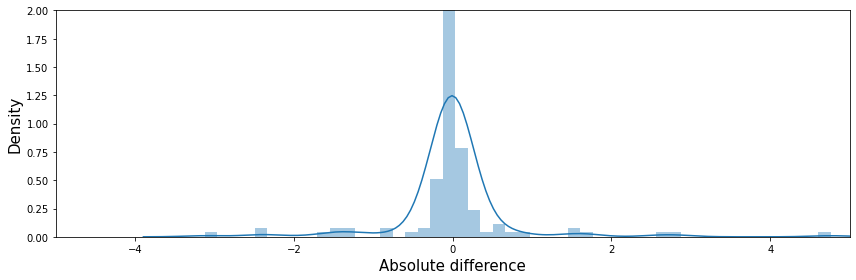

In [11]:
fig, ax = plt.subplots(figsize=(12, 4))
fig.set_tight_layout(True)
sns.distplot(errors, ax=ax);
ax.set_ylim(0, 2)
ax.set_xlim(-5, 5)
ax.set_ylabel('Density', fontsize=15)
ax.set_xlabel('Absolute difference', fontsize=15)
fig.savefig('./figures/Error.pdf')

The red lines drawn in the figure bolow indicate at which point a sample is considered an outlier according to the ART.

/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


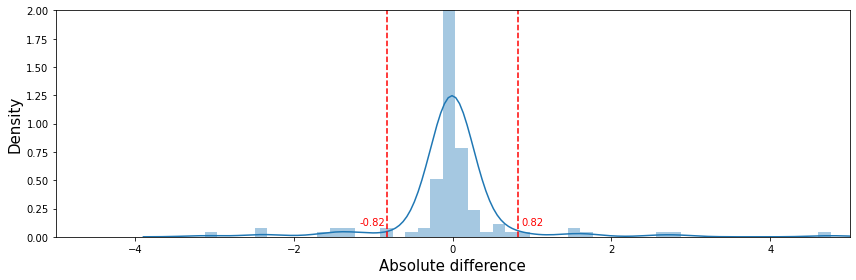

In [12]:
fig, ax = plt.subplots(figsize=(12, 4))
fig.set_tight_layout(True)
sns.distplot(errors, ax=ax)
ax.set_ylim(0, 2)
ax.set_xlim(-5, 5)
ax.axvline(x=limit, ymin=0, color='r', ls='--')
ax.axvline(x=-limit, ymin=0, color='r', ls='--')
ax.annotate(str(round(-limit, 2)), xy=(-limit, 0), xytext=(-limit-0.35, 0.1), color='r')
ax.annotate(str(round(limit, 2)), xy=(limit, 0), xytext=(limit+0.05, 0.1), color='r')
ax.set_xlabel('Absolute difference', fontsize=15)
ax.set_ylabel('Density', fontsize=15)
fig.savefig('./figures/Excluded.pdf')

## Step 4: RUNNING ART!!!!!

Now that the data is correctly structured and the outlier have been removed, it is time to run the ART. First, the following ART paramaters need to be defined

In [13]:
art_params = {}
art_params['response_vars'] = measurement
art_params['input_vars'] = colnames
art_params['seed'] = 42  # default: None
art_params['num_recommendations'] = 30   
art_params['cross_val'] = True
art_params['recommend'] = False
art_params['output_directory'] = 'results_onehot/'


Training the ART takes some time. Fortunatly, this only needs to be done once. If there is already a trained ART model, it is not needed to run it again.

In [14]:
run_art = True

/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)
/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/pandas/core/internals/blocks.py:938: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
../ART_iGEM/art/core.py:1312: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferen

/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)
/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/pandas/core/internals/blocks.py:938: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degen

/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=8.546e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.304e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: Con

/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=8.546e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=7.035e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: Con

/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.112e-02, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.112e-02, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615:

/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=7.621e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.220e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: Con

/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=6.851e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.635e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: Con

/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=9.047e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=7.175e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: Con

/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=6.979e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=5.599e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: Con

/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=6.086e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.334e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: Con

/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.300e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.859e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: Con

../ART_iGEM/art/core.py:1312: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  self.trace[j] = pm.sample(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 33 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 228 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you mean

The number of effective samples is smaller than 25% for some parameters.
/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)
/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/pandas/core/internals/blocks.py:938: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
../ART_iGEM/art/core.py:1312: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData`

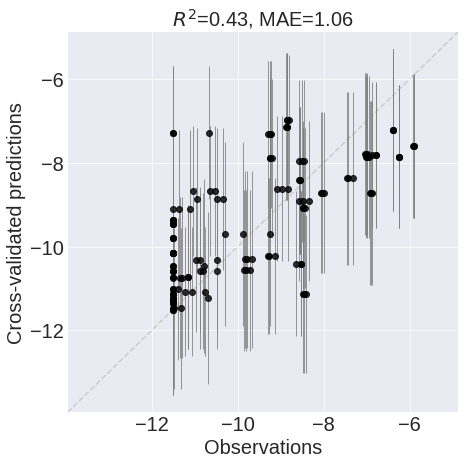

/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)
/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/pandas/core/internals/blocks.py:938: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
../ART_iGEM/art/core.py:1312: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferen

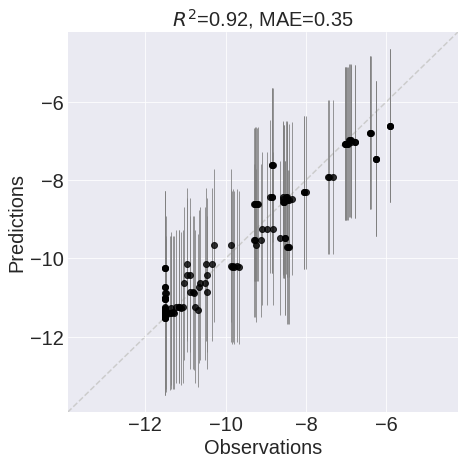

CPU times: user 58min 35s, sys: 56min 30s, total: 1h 55min 6s
Wall time: 54min 17s


In [15]:
%%time
if run_art:
    art = RecommendationEngine(samples_art_oneh_filtered, **art_params)
else:
    with open('results_onehot/art.pkl', 'rb') as output:
        art = pickle.load(output)

## Step 5: Starting with analysis of the data

After having trained the ART, it is time to interpret the results from the ART. The ultimate goal is to find out how acturate the predictions made by the ART will be on samples which have not been tested. Unfortunatly, this is impossible as it is unknown what exact activity of the untested samples will be. The best we can do, is give an approximation.

A powerfull tool for this approximation is *k-fold cross-validation*. The idea is to split the entire dataset into `k` (almost) equally sized *folds*. Afterwards, the model is trained `k` times, where each time one of the folds is excluded from the training data. Once training is done, the model is validated on the fold that was excluded from the training data. This gives an approximation of what would happen is the model would encounter new samples. The error between the predictions and the actual measurements can be used to determine the Mean Absolute Error (MAE), Mean Relative Absolute Error (MRAE), standard deviation of the Absolute Error (stdAE), Mean Squared Error (MSE) and $R^2$ value of the model. The most important parametric to look at is the $R^2$ value as it represents how well the model is able to explain the validation data. An $R^2$-value of $1.0$ means that the model is able to explain 100% of the data. A value of $0.0$ or less means non of the data can be explained by the model. 

This process of *k-fold cross-validation* can be repeated for all the models used to construct the final `Ensamble Model`. The ensamble model should yield (one of) the highest $R^2$-values.

In [16]:
art.evaluate_models_cv()

,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,2.049744,21.533226,1.397372,6.154099,-0.952493
Random Forest Regressor,0.931505,10.327936,0.796264,1.501738,0.523548
TPOT Regressor,0.989244,10.784418,0.858730,1.716019,0.455564
Support Vector Regressor,1.196905,13.714298,0.747021,1.990622,0.368441
Kernel Ridge Regressor,5.672472,56.142421,2.422479,38.045344,-11.070532
K-NN Regressor,1.515206,17.285138,1.000863,3.297576,-0.046212
Gaussian Process Regressor,1.207093,13.678673,0.772766,2.054241,0.348257
Gradient Boosting Regressor,1.088989,11.807128,0.875456,1.952321,0.380593
Ensemble Model,1.056029,11.470180,0.819734,1.787161,0.432993


The $R^2$-value is a good first indication on how will the model is able to explain the data. However, further analysis is needed in order to check if there are unexpected patterns in the predictions (e.g. an outlier). A correlation plot can be used for this purpose. A correlation plot between the observerd and the predicted measurement should yield a straight diagonal line if the model is able to make perfect predictions (i.e. the observed measurement = predicted measurment). 

The plot below shows the crossvalidated ensemble prediction compared to observations of mean productivity of library and control strains (i.e. the unused folds during the k-fold cross-validation)


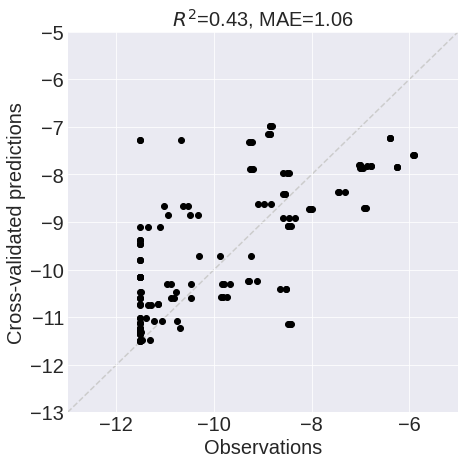

In [20]:
plot.predictions_vs_observations(art, cv_flag=True, errorbars_flag=False, xlim=[[-13, -5]], ylim=[[-13, -5]], log=False)

Chances are the plot above is does not show a nice diagonal line. This could have a range of different causes. To only list a few:

1. The measuring error is too big
2. The pattern generating the activity values is too complex to learn based on the current set of training samples
3. The model is undertrained
4. The model is over trained

At his point, not much can be done about the first two points. Reducing the measuring error is likely to require a complete re-design of the experiment. The second problem could possibly be mitigated with attitional training samples, although there is no guarantee that this would work. Point three can be checked relatively easily by checking the non-cross-validated corralation plot. If the non-cross-validated model is able to accurately reproduce the its training data, the model is likely to have learned enough to prevent underfitting. This corraltion graph is shown in the cell below

Check wether the model is over trained (point 4), most often requires a deeper analysis of the learning curves of the models. **TODO: fix the script for generating the learning curves two cells down**



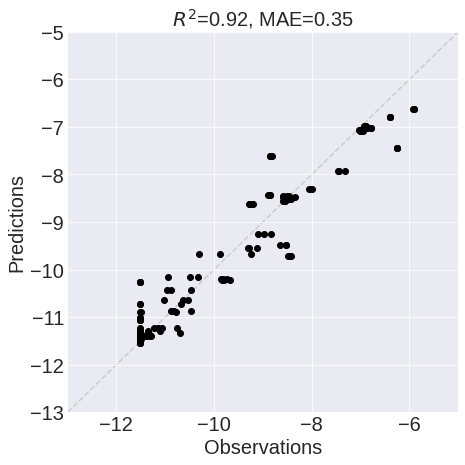

In [21]:
plot.predictions_vs_observations(art, cv_flag=False, errorbars_flag=False, xlim=[[-13, -5]], ylim=[[-13, -5]], log=False)

### learning curves

10 cross-validation runs were performed in parallel running the script `learning_curves_per_set_size.py` with arguments `run_number` and `set_index` (between 0 and 14 for a total of 15 cases). The results were stored in

## TODO:
Adapt the `learning_curves_per_set_size.py` such that it is applicable to our dataset (see Zang, Petersen & Radivojević et al. (2020))

In [82]:
output_directory = './results_onehot/learning_curves'

In [83]:
num_runs = 10
metrics_all = {}
for run in range(num_runs):
    filename = f'{output_directory}/metrics_train_test_{run+1}.pkl'
    with open(filename, 'rb') as f:
        metrics_all[run] = pickle.load(f) 

FileNotFoundError: [Errno 2] No such file or directory: './results_onehot/learning_curves/metrics_train_test_1.pkl'

## Step 6: Using the ART for making predicitons

Now that the ART is all trained and well, 

In [66]:
cv_prediction = np.array(art.model_df_cv[0]['Predictions']['Ensemble Model'])
print(len(cv_prediction))
print(len(samples_art_oneh_filtered['Line Name'].unique()))
predicted_mean, predicted_std = art.post_pred_stats(art.load_input_data(scale=False))

jbei_library_pred_df = pd.DataFrame({'Line Name' : samples_art_oneh_filtered['Line Name'].unique(),'prediction' : predicted_mean.squeeze(), 'cv_prediction' : cv_prediction})
jbei_library_pred_df['Line Name'], jbei_library_pred_df['Replicate'] = jbei_library_pred_df['Line Name'].str.split('-', 1).str
print(jbei_library_pred_df)
8# jbei_library_pred_df.head()

144
144
    Line Name  prediction  cv_prediction Replicate
0         #01   -6.613506      -7.594097        r0
1         #01   -6.613506      -7.594097        r1
2         #01   -6.613506      -7.594097        r2
3         #02  -10.635212      -8.672763        r0
4         #02  -10.635212      -8.672763        r1
..        ...         ...            ...       ...
139       #62  -11.233402     -10.727091        r1
140       #62  -11.233402     -10.727091        r2
141       #63   -8.309340      -8.720476        r0
142       #63   -8.309340      -8.720476        r1
143       #63   -8.309340      -8.720476        r2

[144 rows x 4 columns]


/tmp/ipykernel_48248/2677260846.py:7: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  jbei_library_pred_df['Line Name'], jbei_library_pred_df['Replicate'] = jbei_library_pred_df['Line Name'].str.split('-', 1).str


In [70]:

print(jbei_library_pred_df.head())
samples = pd.read_csv('Sample_list.csv', sep=',')
print(samples.head())

samples = pd.merge(samples, jbei_library_pred_df,  how='left', left_on=['Line Name', 'Replicate'], right_on = ['Line Name', 'Replicate'])
samples.head()

  Line Name  prediction  cv_prediction Replicate
0       #01   -6.613506      -7.594097        r0
1       #01   -6.613506      -7.594097        r1
2       #01   -6.613506      -7.594097        r2
3       #02  -10.635212      -8.672763        r0
4       #02  -10.635212      -8.672763        r1
  Line Name Replicate          Measurement  str_idx  pro_idx  sec_idx  \
0       #01        r0   -5.919818524250338        2        6       16   
1       #01        r1   -5.911463675062115        2        6       16   
2       #01        r2   -5.900194502930249        2        6       16   
3       #02        r0   -10.52760178576078        4       11       18   
4       #02        r1  -10.644871095979585        4       11       18   

   gen_idx  prediction  cv_prediction  
0       22   -6.613506      -7.594097  
1       22   -6.613506      -7.594097  
2       22   -6.613506      -7.594097  
3       19  -10.635212      -8.672763  
4       19  -10.635212      -8.672763  


,Line Name,Replicate,Measurement,str_idx,pro_idx,sec_idx,gen_idx,prediction,cv_prediction
0,#01,r0,-5.919818524250338,2,6,16,22,-6.613506,-7.594097
1,#01,r1,-5.911463675062115,2,6,16,22,-6.613506,-7.594097
2,#01,r2,-5.900194502930249,2,6,16,22,-6.613506,-7.594097
3,#02,r0,-10.52760178576078,4,11,18,19,-10.635212,-8.672763
4,#02,r1,-10.644871095979585,4,11,18,19,-10.635212,-8.672763


In [25]:
num_strains = 4
indeces_strains = np.array(range(1,num_strains+1))
num_promoters = 10
indeces_promoters = np.array(range(num_strains+1, num_strains+num_promoters+1))
num_secretion_signals = 4
indeces_secretion = np.array(range(num_strains+num_promoters+1, num_strains+num_promoters+num_secretion_signals+1))
num_genes = 4

In [73]:
num_strains = 4
num_promoters = 10
num_secretion_signals = 4
num_genes = 4

num_designs = num_strains*num_of_promoters*num_secretion_signals*num_of_genes

designs = np.zeros((num_of_designs, num_of_promoters_onehot))

i = 0

strains = np.eye(num_strains)
promoters = np.eye(num_promoters)
seqretion = np.eye(num_secretion_signals)
genes = np.eye(num_genes)

for p1 in strains:
    for p2 in promoters:
        for p3 in seqretion:
            for p4 in genes:
                designs[i,:] = np.hstack((p1,p2,p3,p4)).astype(int)
                i+=1

designs


array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Calculate mean predicted production and standard deviation for all possible designs.

In [74]:
pp_mean, pp_std = art.post_pred_stats(designs)

The relative engineering accuracy is set to one percent to make sure recommendations are different from the input data.

In [28]:
art.rel_eng_accuracy = 0.01

### Exploitative approach

Objective function is defined as the mean predicted production (the parameter for exploration is set to 𝛼=0
).

In [75]:
obj_func = pp_mean 
data = np.hstack((designs, obj_func, obj_func))
print(data)

[[  1.           0.           0.         ...   0.          -9.4308097
   -9.4308097 ]
 [  1.           0.           0.         ...   0.         -10.74291919
  -10.74291919]
 [  1.           0.           0.         ...   0.          -8.75545187
   -8.75545187]
 ...
 [  0.           0.           0.         ...   0.         -11.28655475
  -11.28655475]
 [  0.           0.           0.         ...   0.         -10.62197781
  -10.62197781]
 [  0.           0.           0.         ...   1.          -8.51006162
   -8.51006162]]


In [76]:
art.recommend(data=data)
ind_max = np.argmax(art.recommendations.values[:,-1])
mean, std = art.post_pred_stats(art.recommendations.values[ind_max,:-1])
print(f'Mean and standard deviation of the recommendation with the highest predicted production are: {mean[0][0]:.2f}, {std[0][0]:.2f}')

../ART_iGEM/art/core.py:1610: RuntimeWarning: divide by zero encountered in double_scalars
  np.abs(new_rec[l] - previous_points[k][l])
../ART_iGEM/art/core.py:1610: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(new_rec[l] - previous_points[k][l])


Mean and standard deviation of the recommendation with the highest predicted production are: -6.61, 1.00


In [78]:
df_rec_categ_exploit = pd.DataFrame(index=art.recommendations.index, columns=['strain','promoter','seqretion','gene',measurement[0]])
for i in range(art.num_recommendations):
    rec = art.recommendations.iloc[i][np.round(art.recommendations.values[i,:]).astype('int64') != 0]
    df_rec_categ_exploit.iloc[i][('strain','promoter','seqretion','gene')] = [int(float(p.split('_')[2])) for p in rec.index[:-1]]
    df_rec_categ_exploit.iloc[i][measurement] = rec[measurement]

df_rec_categ_exploit['Predicted activity'] = np.exp(np.array(df_rec_categ_exploit[measurement].values.tolist()))

df_rec_categ_exploit

,strain,promoter,seqretion,gene,Measurement,Predicted activity
0,1,12,16,22,-6.608727,0.001349
1,3,6,16,22,-6.650891,0.001293
2,3,5,16,22,-6.722348,0.001204
3,1,6,16,22,-6.738403,0.001185
4,4,6,16,22,-6.739964,0.001183
5,2,12,16,22,-6.784899,0.001131
6,2,5,16,22,-6.837965,0.001072
7,1,8,16,22,-6.851863,0.001057
8,1,11,16,22,-6.853684,0.001056
9,1,5,16,22,-6.901453,0.001006


In [32]:
df_rec_categ_exploit.nunique()

strain          4
promoter       10
seqretion       1
gene            1
Measurement    30
dtype: int64